In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import random
import shutil
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

In [4]:
dataset_dir = 'genres_original/'
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Finished: blues
Finished: classical
Finished: country
Finished: disco
Finished: hiphop
Finished: jazz
Finished: metal
Finished: pop
Finished: reggae
Finished: rock


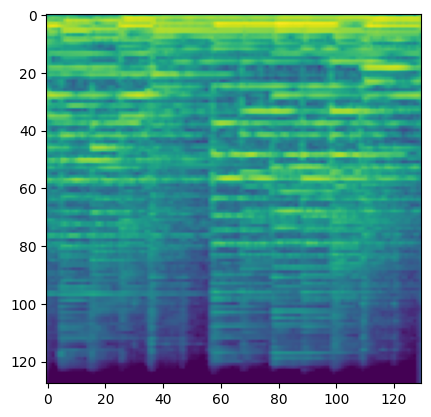

In [5]:
for genre_index, genre_label in enumerate(genre_labels):
    i = 0
    genre_dir = os.path.join(dataset_dir, genre_label)

    for file in os.listdir(genre_dir):
        file_path = os.path.join(genre_dir, file)
        i = i + 1
        
        y, sr = librosa.load(file_path, duration=3)
        mels = librosa.feature.melspectrogram(y=y, sr=sr)
        
        fig = plt.Figure()
        canvas = FigureCanvasAgg(fig)
        p = plt.imshow(librosa.power_to_db(mels, ref=np.max))
        
        path = f'./spectrograms/train/{genre_label}/'
        if not os.path.exists(path):
            os.makedirs(path)
        
        plt.savefig(f'./spectrograms/train/{genre_label}/{genre_label}{i}.png')
        
    print('Finished:', genre_label)

In [3]:
directory = './spectrograms/train/'

for genre in genre_labels:
    filenames = os.listdir(os.path.join(directory, f"{genre}"))
    
    random.shuffle(filenames)
    test_files = filenames[0:20]
    
    for file in test_files:
        path = f"{directory[:-6]}test/{genre}"
        if not os.path.exists(path):
            os.makedirs(path)
        
        shutil.move(f"{directory}{genre}/{file}", path)

NameError: name 'genre_labels' is not defined

In [5]:
train_directory = directory
train_data_generator = ImageDataGenerator(rescale=1./255)

validation_directory = f"{directory[:-6]}test/"
validation_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(train_directory, target_size=(
    288, 432), color_mode="rgba", class_mode='categorical', batch_size=128)

validation_generator = validation_data_generator.flow_from_directory(validation_directory, target_size=(
    288, 432), color_mode='rgba', class_mode='categorical', batch_size=128)

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [6]:
def cnn(input_shape=(288, 432, 4), classes=10):
    def step(dim, X):
        X = Conv2D(dim, kernel_size=(3, 3), strides=(1, 1))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        return MaxPooling2D((2, 2))(X)
    X_input = Input(input_shape)
    X = X_input
    layer_dims = [8, 16, 32, 64, 128, 256]
    for dim in layer_dims:
        X = step(dim, X)

    X = Flatten()(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(classes, activation='softmax',
              name=f'fc{classes}',  kernel_initializer=glorot_uniform(seed=9))(X)
    model = Model(inputs=X_input, outputs=X, name='cnn')
    return model

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [7]:
model = cnn(input_shape=(288, 432, 4), classes=10)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [9]:
history = model.fit(train_generator, epochs=100, validation_data=validation_generator)

Epoch 1/100
7/7 [==============================] - 12s 1s/step - loss: 2.9905 - accuracy: 0.0887 - f1_score: 0.0243 - val_loss: 2.3035 - val_accuracy: 0.1000 - val_f1_score: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 2.7381 - accuracy: 0.1300 - f1_score: 0.0392 - val_loss: 2.3035 - val_accuracy: 0.1000 - val_f1_score: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 2.5451 - accuracy: 0.1562 - f1_score: 0.0356 - val_loss: 2.3039 - val_accuracy: 0.1000 - val_f1_score: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 2.3951 - accuracy: 0.1813 - f1_score: 0.0440 - val_loss: 2.3048 - val_accuracy: 0.1000 - val_f1_score: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 2.3469 - accuracy: 0.2000 - f1_score: 0.0780 - val_loss: 2.3061 - val_accuracy: 0.1000 - val_f1_score: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 2.2901 - 

Epoch 46/100
7/7 [==============================] - 8s 1s/step - loss: 0.7739 - accuracy: 0.7663 - f1_score: 0.6902 - val_loss: 3.1071 - val_accuracy: 0.1250 - val_f1_score: 0.1253
Epoch 47/100
7/7 [==============================] - 8s 1s/step - loss: 0.7372 - accuracy: 0.7825 - f1_score: 0.7318 - val_loss: 3.0042 - val_accuracy: 0.1350 - val_f1_score: 0.1298
Epoch 48/100
7/7 [==============================] - 8s 1s/step - loss: 0.7504 - accuracy: 0.7812 - f1_score: 0.7367 - val_loss: 3.0026 - val_accuracy: 0.1550 - val_f1_score: 0.1259
Epoch 49/100
7/7 [==============================] - 8s 1s/step - loss: 0.7071 - accuracy: 0.7862 - f1_score: 0.7439 - val_loss: 2.9234 - val_accuracy: 0.1850 - val_f1_score: 0.1365
Epoch 50/100
7/7 [==============================] - 8s 1s/step - loss: 0.6923 - accuracy: 0.8000 - f1_score: 0.7579 - val_loss: 2.9022 - val_accuracy: 0.1800 - val_f1_score: 0.1260
Epoch 51/100
7/7 [==============================] - 8s 1s/step - loss: 0.6583 - accuracy: 0.807

7/7 [==============================] - 8s 1s/step - loss: 0.2363 - accuracy: 0.9575 - f1_score: 0.9410 - val_loss: 1.1999 - val_accuracy: 0.5850 - val_f1_score: 0.5328
Epoch 92/100
7/7 [==============================] - 8s 1s/step - loss: 0.2385 - accuracy: 0.9675 - f1_score: 0.9573 - val_loss: 1.1939 - val_accuracy: 0.5550 - val_f1_score: 0.4932
Epoch 93/100
7/7 [==============================] - 8s 1s/step - loss: 0.2428 - accuracy: 0.9563 - f1_score: 0.9411 - val_loss: 1.1883 - val_accuracy: 0.5750 - val_f1_score: 0.5418
Epoch 94/100
7/7 [==============================] - 8s 1s/step - loss: 0.2214 - accuracy: 0.9625 - f1_score: 0.9475 - val_loss: 1.1757 - val_accuracy: 0.5900 - val_f1_score: 0.5160
Epoch 95/100
7/7 [==============================] - 8s 1s/step - loss: 0.2287 - accuracy: 0.9600 - f1_score: 0.9494 - val_loss: 1.1598 - val_accuracy: 0.5900 - val_f1_score: 0.5704
Epoch 96/100
7/7 [==============================] - 8s 1s/step - loss: 0.2062 - accuracy: 0.9725 - f1_score:

In [10]:
model.save('genre_model.h5', save_format='h5')

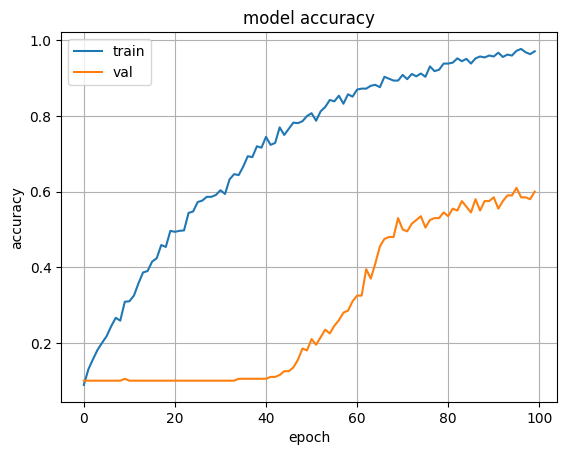

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

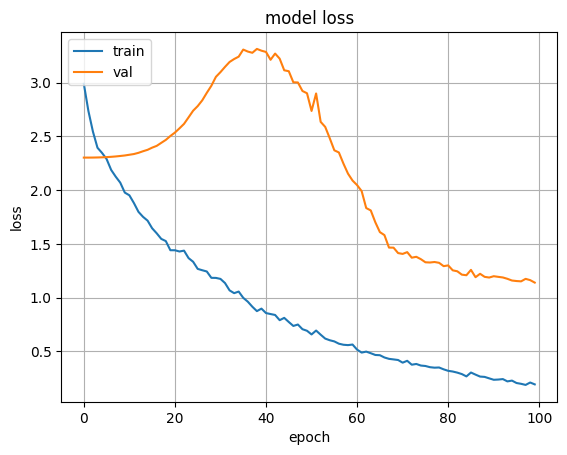

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
def predict(image_data, model):
    image = img_to_array(image_data).reshape((1, 288, 432, 4))
    prediction = model.predict(image / 255)
    prediction = prediction.reshape((10, ))
    class_label = np.argmax(prediction)
    return class_label, prediction

1/1 [==============================] - 0s 18ms/step
8


C:\Users\alexr\AppData\Local\Temp\ipykernel_17328\382581671.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap('jet')


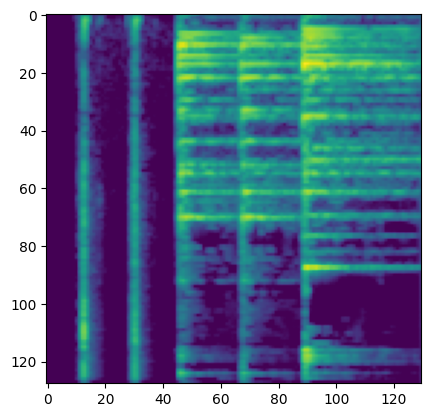

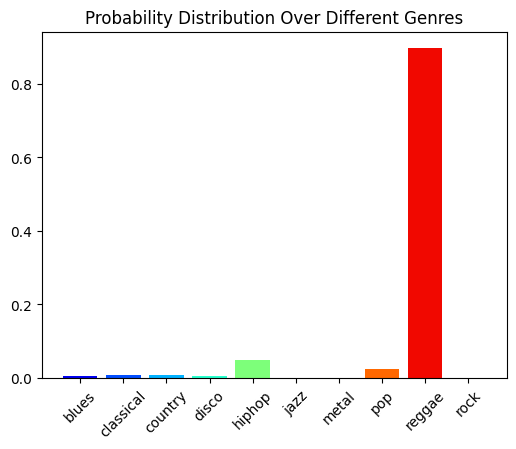

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import streamlit as st

test_file = 'song.mp3'

y, sr = librosa.load(test_file, duration=3)
mels = librosa.feature.melspectrogram(y=y, sr=sr)
fig = plt.Figure()
FigureCanvasAgg(fig)
plt.imshow(librosa.power_to_db(mels, ref=np.max))
plt.savefig('melspectrogram.png')

image_data = load_img('melspectrogram.png', color_mode='rgba', target_size=(288, 432))

class_label, prediction = predict(image_data, model)
prediction = prediction.reshape((10,))

print(class_label)

color_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=10)

st.write(f"### Genre Prediction: {genre_labels[class_label]}")
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.bar(x=genre_labels, height=prediction,
       color=my_cmap(my_norm(color_data)))
plt.xticks(rotation=45)
ax.set_title(
    "Probability Distribution Over Different Genres")
st.pyplot(fig)

st.write(f"### Mel Spectrogram")
st.image("melspectrogram.png", use_column_width=True)
plt.show()